In [ ]:
!pip install underthesea gensim h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import re
from collections import Counter
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization,
    Bidirectional, Input, Layer, Masking, concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

**1. Kết Nối GGDrive**

In [ ]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Thiết lập đường dẫn
root_path = "/content/drive/MyDrive/PBL6"
data_path = os.path.join(root_path, "DATASET")
voca_path = os.path.join(root_path, "voca.txt")

Mounted at /content/drive


**2. Load dữ liệu**

In [ ]:
# Tải dữ liệu
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
validation_df = pd.read_csv(os.path.join(data_path, "validation.csv"))

# Kiểm tra dữ liệu
print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())
print("\nValidation Data:")
print(validation_df.head())

# Kiểm tra phân bố nhãn
print("Phân bố nhãn trong tập Train:")
print(train_df['label'].value_counts())
print("\nPhân bố nhãn trong tập Test:")
print(test_df['label'].value_counts())
print("\nPhân bố nhãn trong tập Validation:")
print(validation_df['label'].value_counts())

Train Data:
                                              review  label
0                                   âm_thanh cũng ổn      1
1                                    âm_thanh dở quá      0
2                                    âm_thanh dở quá      0
3                      âm_thanh hay to rõ chất lương      1
4  âm_thanh loa nhỏ không kết_nối đề_nghị gửi trả...      0

Test Data:
                                              review  label
0  gởi hàng đúng quảng_cáo giá rẻ dùng ok giá thì...      1
1                                 dễ sử_dụng bảo_trì      1
2  hàng đóng_gói cẩn_thận chất_lượng sản_phẩm ổn ...      1
3  ổn mới mua về chưa sạc nên đèn hơi yếu cắm điệ...      0
4                             hàng giả nha mọi người      0

Validation Data:
                                              review  label
0  đặt_hàng giao thiếu hàng nhan tin thì không th...      0
1  bền không thấm nước sử_dụng hiệu_quả giá rẻ áo...      1
2  đóng_gói cẩn_thận cửa_hàng_giáo hàng nhanh sản...      

**3. Tạo Từ Điển với Token `<PAD>` Riêng Biệt**

In [ ]:
from collections import Counter

# Xây dựng từ điển từ tập train với min_count=2
all_words = ' '.join(train_df['review']).split()
word_counts = Counter(all_words)
sorted_words = word_counts.most_common()

min_count = 2
filtered_words = [word for word, count in sorted_words if count >= min_count]

# Khởi tạo từ điển với các token đặc biệt
vocab = {'<PAD>': 0, 'digit': 1, 'unknown': 2}
for idx, word in enumerate(filtered_words, start=3):
    vocab[word] = idx

# Lưu từ điển vào file voca.txt
with open(voca_path, 'w', encoding='utf-8') as f:
    for word, idx in vocab.items():
        f.write(f"{word}\t{idx}\n")

print(f"Size of vocabulary after filtering: {len(vocab)}")

Size of vocabulary after filtering: 1713


**4. Vector hóa**

In [ ]:
def text_to_sequence(text, vocab):
    words = text.split()
    sequence = []
    for word in words:
        if word.isdigit():
            sequence.append(vocab.get('digit', 1))
        elif word in vocab:
            sequence.append(vocab[word])
        else:
            sequence.append(vocab.get('unknown', 2))
    return sequence

# # Tìm độ dài tối đa của các câu trong tập dữ liệu
# all_lengths = train_df['review'].apply(lambda x: len(x.split()))
max_length = 25


# Áp dụng pad_sequences với token `<PAD>`
X_train = pad_sequences(
    train_df['review'].apply(lambda x: text_to_sequence(x, vocab)).tolist(),
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=vocab['<PAD>']
)
y_train = np.array(train_df['label'].tolist())

X_test = pad_sequences(
    test_df['review'].apply(lambda x: text_to_sequence(x, vocab)).tolist(),
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=vocab['<PAD>']
)
y_test = np.array(test_df['label'].tolist())

X_validation = pad_sequences(
    validation_df['review'].apply(lambda x: text_to_sequence(x, vocab)).tolist(),
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=vocab['<PAD>']
)
y_validation = np.array(validation_df['label'].tolist())

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of X_validation: {X_validation.shape}")

# Đọc lại từ điển
with open(voca_path, 'r', encoding='utf-8') as f:
    vocab_loaded = {line.split('\t')[0]: int(line.split('\t')[1]) for line in f.readlines()}

print(f"Index of '<PAD>': {vocab_loaded.get('<PAD>', 'Not Found')}")
print(f"Index of 'digit': {vocab_loaded.get('digit', 'Not Found')}")
print(f"Index of 'unknown': {vocab_loaded.get('unknown', 'Not Found')}")

# Tính tỷ lệ các từ "unknown" trong tập huấn luyện và validation
unknown_train = np.sum(X_train == vocab['unknown'])
total_train = X_train.size
print(f"Tỷ lệ 'unknown' trong tập huấn luyện: {unknown_train / total_train * 100:.2f}%")

unknown_val = np.sum(X_validation == vocab['unknown'])
total_val = X_validation.size
print(f"Tỷ lệ 'unknown' trong tập validation: {unknown_val / total_val * 100:.2f}%")

Shape of X_train: (3328, 25)
Shape of X_test: (418, 25)
Shape of X_validation: (416, 25)
Index of '<PAD>': 0
Index of 'digit': 1
Index of 'unknown': 2
Tỷ lệ 'unknown' trong tập huấn luyện: 0.99%
Tỷ lệ 'unknown' trong tập validation: 2.27%


**5. Tạo Ma Trận Embedding với Token `<PAD>`**

In [ ]:
from gensim.models import Word2Vec
# Xây dựng mô hình Word2Vec từ tập train
sentences = [text.split() for text in train_df['review']]
word2vec_model = Word2Vec(sentences, vector_size=128, window=5, min_count=2, workers=4)
# Tạo ma trận embedding
embedding_dim = 128
embedding_matrix = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))
# Khởi tạo vector cho các token đặc biệt
embedding_matrix[vocab['<PAD>']] = np.zeros(embedding_dim)  # Vector padding là 0
embedding_matrix[vocab['digit']] = np.random.normal(scale=0.6, size=(embedding_dim,))
embedding_matrix[vocab['unknown']] = np.random.normal(scale=0.6, size=(embedding_dim,))
# Cập nhật embedding cho các từ trong Word2Vec
for word, idx in vocab.items():
    if word in word2vec_model.wv and word not in ['<PAD>', 'digit', 'unknown']:
        embedding_matrix[idx] = word2vec_model.wv[word]
print(f"Shape of embedding_matrix: {embedding_matrix.shape}")

Shape of embedding_matrix: (1713, 128)


**6. Xây Dựng Mô Hình với Masking và Các Lớp CNN & LSTM**

In [ ]:
# Định nghĩa đầu vào
input_layer = Input(shape=(max_length,), name='Input')

# Lớp Masking để bỏ qua các vị trí padding
masking_layer = Masking(mask_value=vocab['<PAD>'], name='Masking')(input_layer)

# Lớp Embedding sử dụng ma trận embedding đã tạo
embedding_layer = Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True,  # Cho phép tinh chỉnh embedding
    name='Embedding'
)(masking_layer)

# Lớp CNN với nhiều kernel_size khác nhau và padding='same'
conv_filters = []
kernel_sizes = [2, 3, 4]  # Các kích thước bộ lọc

for kernel_size in kernel_sizes:
    conv = Conv1D(
        filters=64,  # Giảm số lượng filters từ 128 xuống 64
        kernel_size=kernel_size,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001),
        name=f'Conv1D_{kernel_size}'
    )(embedding_layer)
    conv = BatchNormalization(name=f'BatchNorm_{kernel_size}')(conv)
    conv = MaxPooling1D(pool_size=2, padding='same', name=f'MaxPool_{kernel_size}')(conv)
    conv = Dropout(0.3, name=f'Dropout_{kernel_size}')(conv)  # Tăng dropout lên 0.3
    conv_filters.append(conv)

# Kết hợp các đặc trưng từ các lớp Conv khác nhau
merged_conv = concatenate(conv_filters, axis=-1, name='Concatenate_Conv')

# Lớp LSTM Bidirectional
lstm_layer = Bidirectional(LSTM(
    units=64,  # Giảm số lượng units từ 128 xuống 64
    dropout=0.3,
    recurrent_dropout=0.3,
    return_sequences=True,
    name='BiLSTM_64'
))(merged_conv)

lstm_layer = Bidirectional(LSTM(
    units=32,  # Giảm số lượng units từ 64 xuống 32
    dropout=0.3,
    recurrent_dropout=0.3,
    name='BiLSTM_32'
))(lstm_layer)

# Lớp Dense
dense_layer = Dense(
    units=32,  # Giảm số lượng units từ 64 xuống 32
    activation='relu',
    kernel_regularizer=l2(0.001),
    name='Dense_32'
)(lstm_layer)
dense_layer = Dropout(0.3, name='Dropout_Dense')(dense_layer)  # Tăng dropout lên 0.3

# Lớp Output
output_layer = Dense(1, activation='sigmoid', name='Output')(dense_layer)

# Tạo mô hình
model = Model(inputs=input_layer, outputs=output_layer)

# Tóm tắt mô hình
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 25)]                 0         []                            
                                                                                                  
 Masking (Masking)           (None, 25)                   0         ['Input[0][0]']               
                                                                                                  
 Embedding (Embedding)       (None, 25, 128)              219264    ['Masking[0][0]']             
                                                                                                  
 Conv1D_2 (Conv1D)           (None, 25, 64)               16448     ['Embedding[0][0]']           
                                                                                            

**7. Biên dịch và định nghĩa checkpoint**

In [ ]:
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)  # Giảm learning rate xuống 1e-4

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callback để lưu lại mô hình tốt nhất dựa trên val_accuracy
checkpoint = ModelCheckpoint(
    filepath=os.path.join(root_path, "best_model.h5"),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback để giảm learning rate khi không cải thiện val_accuracy
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,  # Giảm lr xuống 50% mỗi lần không cải thiện
    patience=3,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

# Callback để dừng huấn luyện sớm khi không cải thiện val_accuracy
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

callbacks = [checkpoint, lr_scheduler, early_stop]

**8. Huấn luyện mô hình**

In [ ]:
# Tính trọng số lớp từ tập Train
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_validation, y_validation),
    callbacks=callbacks,
    class_weight=class_weights  # Thêm class weights
)

Class weights: {0: 1.1358361774744028, 1: 0.8931830381105743}
Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.9505 - accuracy: 0.5987
Epoch 1: val_accuracy improved from -inf to 0.56010, saving model to /content/drive/MyDrive/PBL6/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 11s 62ms/step - loss: 0.9514 - accuracy: 0.5962 - val_loss: 0.9626 - val_accuracy: 0.5601 - lr: 1.0000e-04
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.9276 - accuracy: 0.6124
Epoch 2: val_accuracy improved from 0.56010 to 0.59135, saving model to /content/drive/MyDrive/PBL6/best_model.h5
52/52 [==============================] - 2s 37ms/step - loss: 0.9273 - accuracy: 0.6124 - val_loss: 0.9453 - val_accuracy: 0.5913 - lr: 1.0000e-04
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.8898 - accuracy: 0.6627
Epoch 3: val_accuracy improved from 0.59135 to 0.61058, saving model to /content/drive/MyDrive/PBL6/best_model.h5
52/52 [==============================] - 2s 36ms/step - loss: 0.8885 - accuracy: 0.6629 - val_loss: 0.9243 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.8061 - accuracy: 0.7577
Epoch 4: val_accuracy improved from 0.61058 t

**9. Đánh giá trên tập test và trục quan biểu độ loss, acc**

In [ ]:
# Đánh giá trên tập test
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


14/14 [==============================] - 0s 9ms/step - loss: 0.3619 - accuracy: 0.9617
Test Loss: 0.36185652017593384
Test Accuracy: 0.9617224931716919


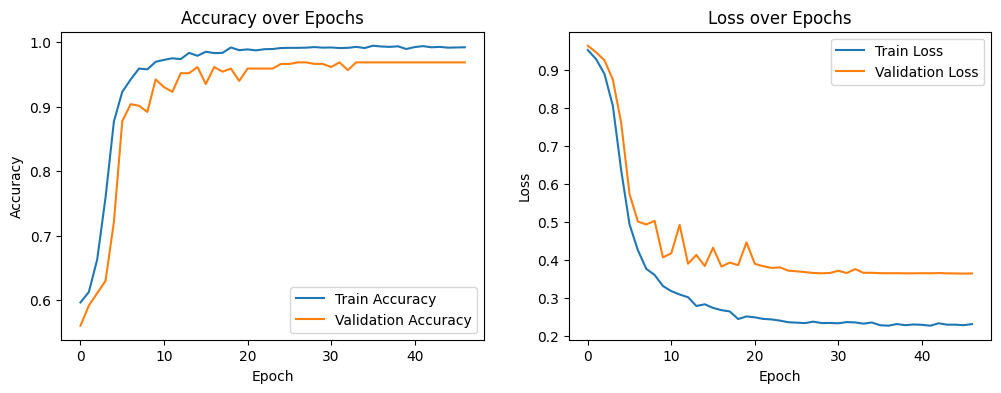

In [ ]:
import matplotlib.pyplot as plt

# Vẽ đồ thị Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ đồ thị Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


**10. Save Model**


In [ ]:
model.save(os.path.join(root_path, "best_model.h5"))
print("Đã lưu mô hình vào '/content/drive/MyDrive/PBL6/best_model.h5'")

Đã lưu mô hình vào '/content/drive/MyDrive/PBL6/best_model.h5'


**11. Test Model**

Loaded vocabulary size: 1713
Loaded Test1 Data:
                                              review  label
0  gởi hàng đúng quảng_cáo giá rẻ dùng ok giá thì...      1
1                                 dễ sử_dụng bảo_trì      1
2  hàng đóng_gói cẩn_thận chất_lượng sản_phẩm ổn ...      1
3  ổn mới mua về chưa sạc nên đèn hơi yếu cắm điệ...      0
4                             hàng giả nha mọi người      0
Shape of X_test1: (418, 25)
Shape of y_test1: (418,)
Model loaded successfully.
14/14 [==============================] - 1s 18ms/step
Accuracy: 0.9617
Precision: 0.9619
Recall: 0.9701
F1-Score: 0.9660
AUC-ROC: 0.9831

Classification Report:
              precision    recall  f1-score   support

           0     0.9615    0.9511    0.9563       184
           1     0.9619    0.9701    0.9660       234

    accuracy                         0.9617       418
   macro avg     0.9617    0.9606    0.9611       418
weighted avg     0.9617    0.9617    0.9617       418



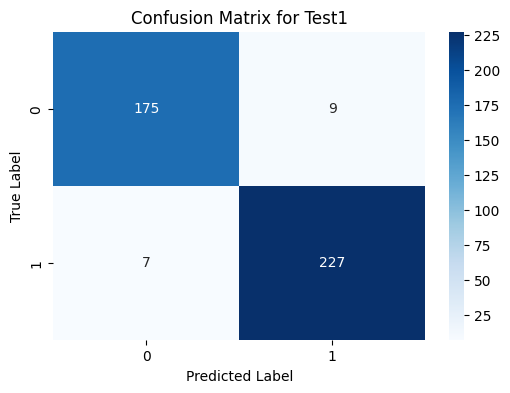

Predictions saved to /content/drive/MyDrive/PBL6/DATASET/test1_predictions.csv


In [ ]:
# 1. Import Các Thư Viện Cần Thiết
import numpy as np
import pandas as pd
import os
from collections import Counter
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Định Nghĩa Đường Dẫn Tới Các Tệp Dữ Liệu và Mô Hình
root_path = "/content/drive/MyDrive/PBL6"  # Thay đổi nếu cần
data_path = os.path.join(root_path, "DATASET")
voca_path = os.path.join(root_path, "voca.txt")
model_path = os.path.join(root_path, "best_model.h5")
test1_path = os.path.join(data_path, "test.csv")  # Đường dẫn tới test1.txt

# 3. Load Từ Điển Từ voca.txt
vocab = {}
with open(voca_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            word, idx = parts
            vocab[word] = int(idx)

print(f"Loaded vocabulary size: {len(vocab)}")

# 4. Load và Tiền Xử Lý Dữ Liệu từ test1.txt
# Giả sử test1.txt là CSV với các cột 'review' và 'label'
test1_df = pd.read_csv(test1_path)
print("Loaded Test1 Data:")
print(test1_df.head())

# Kiểm tra xem có cột 'label' không
has_labels = 'label' in test1_df.columns

# Hàm chuyển đổi văn bản thành chuỗi số
def text_to_sequence(text, vocab):
    """
    Chuyển đổi văn bản thành chuỗi số dựa trên từ điển.
    Giữ nguyên thứ tự từ trong câu.
    """
    words = text.split()
    sequence = []
    for word in words:
        if word.isdigit():
            sequence.append(vocab.get('digit', 1))
        elif word in vocab:
            sequence.append(vocab[word])
        else:
            sequence.append(vocab.get('unknown', 2))
    return sequence

max_length = 25  # Đã được yêu cầu

# Chuyển đổi và pad chuỗi
X_test1 = pad_sequences(
    test1_df['review'].apply(lambda x: text_to_sequence(x, vocab)).tolist(),
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=vocab['<PAD>']
)

# Nếu có nhãn, lấy nhãn
if has_labels:
    y_test1 = test1_df['label'].values
else:
    y_test1 = None

print(f"Shape of X_test1: {X_test1.shape}")
if has_labels:
    print(f"Shape of y_test1: {y_test1.shape}")

# 5. Load Mô Hình Đã Huấn Luyện
model = load_model(model_path)
print("Model loaded successfully.")

# 6. Dự Đoán Nhãn Cho Dữ Liệu Mới
y_pred_prob = model.predict(X_test1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 7. So Sánh Nhãn Thực Tế với Nhãn Dự Đoán và Tính Các Chỉ Số Đánh Giá
if has_labels:
    accuracy = accuracy_score(y_test1, y_pred)
    precision = precision_score(y_test1, y_pred, zero_division=0)
    recall = recall_score(y_test1, y_pred, zero_division=0)
    f1 = f1_score(y_test1, y_pred, zero_division=0)
    auc = roc_auc_score(y_test1, y_pred_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test1, y_pred, digits=4))

    # 8. Hiển Thị Ma Trận Confusion Matrix
    cm = confusion_matrix(y_test1, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Test1')
    plt.show()

    # 9. Lưu Kết Quả Dự Đoán (Tuỳ Chọn)
    # Thêm cột dự đoán vào dataframe
    test1_df['predicted_label'] = y_pred
    # Lưu vào tệp mới
    output_path = os.path.join(data_path, "test1_predictions.csv")
    test1_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")
else:
    # Nếu không có nhãn thực tế, chỉ in ra dự đoán
    print("No labels available in 'test1.txt'. Predictions:")
    test1_df['predicted_label'] = y_pred
    print(test1_df.head())
    # Lưu dự đoán vào tệp mới
    output_path = os.path.join(data_path, "test1_predictions.csv")
    test1_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")
